In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip uninstall qiskit
!pip install qiskit==0.23.0
#!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
!pip install pylatexenc

     |████████████████████████████████| 8.5 MB 5.2 MB/s 
     |████████████████████████████████| 17.5 MB 127 kB/s 
     |████████████████████████████████| 194 kB 73.6 MB/s 
     |████████████████████████████████| 203 kB 73.9 MB/s 
     |████████████████████████████████| 2.1 MB 45.9 MB/s 
     |████████████████████████████████| 200 kB 71.0 MB/s 
     |████████████████████████████████| 635 kB 66.3 MB/s 
     |████████████████████████████████| 1.4 MB 45.1 MB/s 
     |████████████████████████████████| 108 kB 75.6 MB/s 
     |████████████████████████████████| 49 kB 6.2 MB/s 
     |████████████████████████████████| 3.0 MB 47.7 MB/s 
     |████████████████████████████████| 6.3 MB 46.8 MB/s 
  Created wheel for qiskit: filename=qiskit-0.23.0-py3-none-any.whl size=2864 sha256=31e0f515e4a2269dcab0b3f124e23d799d90be80af3bb22cdb115b58bd899a6c
  Stored in directory: /root/.cache/pip/wheels/cd/a7/06/813f3eb5ce09179e18fb91ddf5001bca795e9e20f1521394ab
  Created wheel for python-constraint: filename=py

In [3]:
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import qiskit
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on the GPU")
else:
  device = torch.device("cpu")
  print("Running on the CPU")

Running on the CPU


In [4]:
#np.random.seed = 314

NUM_QUBITS = 4
NUM_SHOTS = 800 #3000
SHIFT = np.pi/4
LEARNING_RATE = 0.0002
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('qasm_simulator')

In [5]:
# create list of all possible outputs of quantum circuit (2**NUM_QUBITS possible)
import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


# Circuit

In [6]:
class QiskitCircuit():
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.thetas = {k : Parameter('Theta'+str(k))for k in range(2*self.n_qubits)}
        
        all_qubits = [i for i in range(n_qubits)]
        self.circuit.h(all_qubits)
        self.circuit.barrier()

        #self.circuit.h(0)

        for k in range(0, 4):
          self.circuit.ry(self.thetas[k], k)

        self.circuit.cx(0, 1)
        self.circuit.cx(0, 2)
        self.circuit.cx(0, 3)
        self.circuit.cx(1, 2)
        self.circuit.cx(1, 2)
        self.circuit.cx(2, 3)

        for k in range(0, 4):
          self.circuit.ry(self.thetas[k+4], k)

        self.circuit.measure_all()
        #self.circuit.measure(1,0)
        # ---------------------------
        
        self.backend = backend
        self.shots = shots
        
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0)/shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
        #print('params = {}'.format(len(params)))
        backend = Aer.get_backend('qasm_simulator')
    
        job_sim = execute(self.circuit,
                              self.backend,
                              shots=self.shots,
                              parameter_binds = [{self.thetas[k] : params[k].item() for k in range(2*NUM_QUBITS)}])
#         
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts, self.shots, NUM_QUBITS)

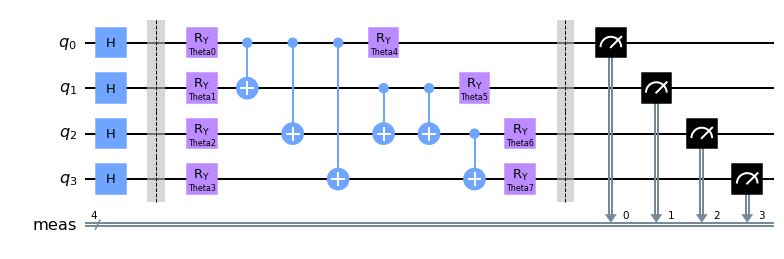

In [7]:
circuit = QiskitCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
#print('Expected value for rotation [pi/4]: {}'.format(circuit.run(torch.Tensor([np.pi/4]*NUM_QUBITS))))
circuit.circuit.draw(output='mpl')#, filename='Figures/{}-qubit circuit ryN.jpg'.format(NUM_QUBITS)

In [8]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
            
        exp_value = ctx.QiskitCirc.run(i)
        
        result = torch.tensor([exp_value])
  
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        
        forward_tensor, i = ctx.saved_tensors
#         print('forward_tensor = {}'.format(forward_tensor))
        input_numbers = i
#         print('input_numbers = {}'.format(input_numbers))
        gradients = torch.Tensor()
        
        for k in range(2*NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
#             print('shift_right = {}, shift_left = {}'.format(shift_right, shift_left))
            
            expectation_right = ctx.QiskitCirc.run(shift_right)
            expectation_left  = ctx.QiskitCirc.run(shift_left)
#             print('expectation_right = {}, \nexpectation_left = {}'.format(expectation_right, expectation_left))
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            # rescale gradient
#             gradient = gradient / torch.norm(gradient)
#             print('gradient for k={}: {}'.format(k, gradient))
            gradients = torch.cat((gradients, gradient.float()))
            
        result = torch.Tensor(gradients)
#         print('gradients = {}'.format(result))
#         print('grad_output = {}'.format(grad_output))

        return (result.float() * grad_output.float()).T

In [9]:
import sys
sys.path.append('/content/drive/MyDrive/QAI4EO/')

In [10]:
from DatasetHandler import DatasetHandler
dataset_root = '/content/drive/MyDrive/QAI4EO/datasets/EuroSAT/EuroSAT'
handler = DatasetHandler(dataset_root)

In [11]:
classes = []
for i, c in enumerate(handler.classes):
  cl = c.split('/')[-1]
  classes.append(cl)
classes.sort()
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [12]:
classes = ['Highway', 'Residential', 'Industrial']

In [13]:
imgs_path, imgs_label = handler.load_paths_labels(dataset_root, classes=classes)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

Dataset images: 7999 Dataset labels: 7999
Dataset sample -> /content/drive/MyDrive/QAI4EO/datasets/EuroSAT/EuroSAT/Residential/Residential_1223.jpg 7


In [14]:
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)
print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape)

X_train shape: (6400,) Y_train shape: (6400,)
  X_val shape:  (1599,)   Y_val shape:  (1599,)


(array([2499.,    0., 2500.,    0.,    0.,    0.,    0.,    0.,    0.,
        3000.]),
 array([3. , 3.4, 3.8, 4.2, 4.6, 5. , 5.4, 5.8, 6.2, 6.6, 7. ]),
 <a list of 10 Patch objects>)

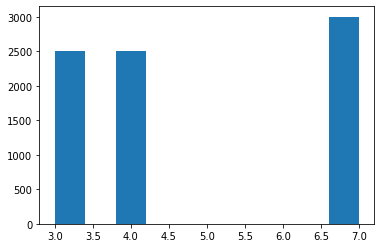

In [15]:
plt.hist(imgs_label, 10)

In [16]:
imgs_label

array([7, 3, 7, ..., 4, 7, 3])

In [17]:
for i in range(len(train_labels)):
  lr = train_labels[i]
  l = 0

  if lr == 3:
    l = 0
  elif lr == 4:
    l = 1
  elif lr == 7:
    l = 2
  
  train_labels[i] = l

for i in range(len(val_labels)):
  lr = val_labels[i]
  l = 0

  if lr == 3:
    l = 0
  elif lr == 4:
    l = 1
  elif lr == 7:
    l = 2
  
  val_labels[i] = l

(array([2499.,    0.,    0.,    0.,    0., 2500.,    0.,    0.,    0.,
        3000.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

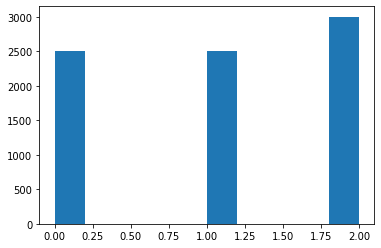

In [18]:
plt.hist(imgs_label, 10)

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)

        #self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(2304, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 42)

        self.fc4 = nn.Linear(2304, 2*NUM_QUBITS)
        
        self.qc = TorchCircuit.apply

        #self.fc5 = nn.Linear(16, 10)
        self.fc5 = nn.Linear(16, 3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))

        x = x.view(-1, 2304)
        #x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        #x = F.relu(self.fc2(x))

        #x = F.relu(self.fc3(x))

        x = self.fc4(x)
        x = np.pi*torch.tanh(x)
        
        x = self.qc(x[0]) # QUANTUM LAYER
        
        x = F.relu(x)
        #print('output of QC = {}'.format(x))
        
#         # softmax rather than sigmoid
        x = self.fc5(x.float())
        #print('output of Linear(1, 2): {}'.format(x))
        x = F.softmax(x, 1)

        #x = torch.sigmoid(x)
        #x = torch.cat((x, 1-x), -1)
        return x
    
    
    def predict(self, x):
        # apply softmax
        pred = self.forward(x)
#         print(pred)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)
    
network = Net()#.to(device)
optimizer = optim.Adam(network.parameters(), lr=0.0002)

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

#from torchsummary import summary
#summary(network, (3, 64, 64))

In [21]:
train_loader = iter(handler.qcnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))

In [22]:
checkpoint = torch.load('/content/drive/MyDrive/QAI4EO/model-real-amp-group2.pt')
network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [23]:
train_loss_list = []
val_loss_list = []
epochs = 25

loss_func = nn.CrossEntropyLoss()

for epoch in range(epochs):
  train_loader = iter(handler.qcnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
  test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
  total_loss = []
  for batch_idx in range(len(train_labels)):
    data, target = next(train_loader) 
    # print(batch_idx)
    optimizer.zero_grad()        
    # Forward pass
    output = network(data)
    # Calculating loss
    loss = loss_func(output, target)
    # Backward pass
    loss.backward()
    # Optimize the weights
    optimizer.step()
    
    total_loss.append(loss.item())
    
    print('\r Epoch %d ~ Batch %d (%d) ~ Loss %f ' % (epoch, batch_idx, len(train_imgs)-1, loss.item()), end='\t\t')
    
  
  with torch.no_grad():
    val_loss = []
    targets = []
    predictions = []
    for batch_idx in range(len(val_images)):
      data, target = next(test_loader)
      output = network(data)
      loss = loss_func(output, target)
      val_loss.append(loss.item())

      targets.append(target.item())
      
      predictions.append(network.predict(data).item())
  
      
  train_loss_list.append(sum(total_loss)/len(total_loss))
  val_loss_list.append(sum(val_loss)/len(val_loss))
  
  print('Training [{:.0f}%]\t Training Loss: {:.4f} Validation Loss: {:.4f}'.format(
      100. * (epoch + 1) / epochs, train_loss_list[-1], val_loss_list[-1]))
  
  if epoch % 3 == 1:
    print(confusion_matrix(targets, predictions,normalize='true'))
    print(classification_report(targets, predictions, target_names=classes, digits=4))
    torch.save({
            'epoch': epoch,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss_list[-1],
            }, '/content/drive/MyDrive/QAI4EO/model-real-amp-group2.pt')
    #torch.save(network.state_dict(), '/content/drive/MyDrive/QAI4EO/model-bell.pt')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


 Epoch 0 ~ Batch 68 (6399) ~ Loss 0.551568 		

KeyboardInterrupt: ignored

In [ ]:
fig, plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('Hybrid NN Training Convergence for {}-qubit'.format(NUM_QUBITS))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend(['Training', 'Validation'])
plt.show()

# Save results

In [24]:
import pandas as pd

In [25]:
checkpoint = torch.load('/content/drive/MyDrive/QAI4EO/model-real-amp-group2.pt')
network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [26]:
coarse_db = pd.read_csv('/content/drive/MyDrive/QAI4EO/coarse_classification.csv')

In [27]:
coarse_db.head()

,Unnamed: 0,PATH,TARGET,FULLTARGET,PREDICTION
0,0,/content/drive/MyDrive/QAI4EO/datasets/EuroSAT...,0,0,0
1,1,/content/drive/MyDrive/QAI4EO/datasets/EuroSAT...,2,8,2
2,2,/content/drive/MyDrive/QAI4EO/datasets/EuroSAT...,0,2,0
3,3,/content/drive/MyDrive/QAI4EO/datasets/EuroSAT...,1,4,1
4,4,/content/drive/MyDrive/QAI4EO/datasets/EuroSAT...,2,9,2


In [28]:
val_images = coarse_db.PATH.values
full_targets = coarse_db.FULLTARGET.values
coarse_prediction = coarse_db.PREDICTION.values

In [29]:
batch_in = np.zeros((1, 3, 64, 64))

full_targets2 = []

with torch.no_grad():
  predictions = []
  for batch_idx in range(len(val_images)):

    if coarse_prediction[batch_idx] == 1:
      batch_in[0,...] = np.transpose(plt.imread(val_images[batch_idx])/255.0)
      output = network.predict(torch.Tensor(batch_in)).item()
      predictions.append(output)
      full_targets2.append(full_targets[batch_idx])

    print('\r  IMG: %d of %d' % (batch_idx, len(val_images)), end='\t\t')
    

  IMG: 5398 of 5399		

In [31]:
len(full_targets2)

1535

In [32]:
len(predictions)

1535

In [33]:
full_targets3 = []

for i in range(len(full_targets2)):
  lr = full_targets2[i]
  
  l = 0

  if lr == 3:
    l = 0
  elif lr == 4:
    l = 1
  elif lr == 7:
    l = 2

  full_targets3.append(l)

In [35]:
print(confusion_matrix(full_targets3, predictions,normalize='true'))
print(classification_report(full_targets3, predictions, target_names=['Highway','Industrial', 'Residential'], digits=4))

[[0.96993988 0.01803607 0.01202405]
 [0.00211416 0.99365751 0.00422833]
 [0.         0.0035524  0.9964476 ]]
              precision    recall  f1-score   support

     Highway     0.9979    0.9699    0.9837       499
  Industrial     0.9771    0.9937    0.9853       473
 Residential     0.9859    0.9964    0.9912       563

    accuracy                         0.9870      1535
   macro avg     0.9870    0.9867    0.9867      1535
weighted avg     0.9871    0.9870    0.9870      1535

